In [450]:
import pandas as pd 
import numpy as np 
import os , sys  
import re 
import networkx as nx 
%store -r data_trad
from IPython.display import clear_output
%store -r Dict  
import matplotlib.pyplot as plt
import spacy 
data=data_trad
discri = Dict.keys()

# Get the data and clean it like a bitch

In [568]:
#data_trad.to_csv('main_data.csv')
data_trad=pd.read_csv('data_final_v7.csv')
%store data_trad

Stored 'data_trad' (DataFrame)


In [569]:
def really_clean(x): 
    return re.sub("[^a-zA-Z]+", " ", x).split(' ')

In [570]:
def BORDEL(x): 
    bien=[] 
    for i in x : 
        if i.isalpha() == True : 
            bien.append(i) 
    
    return bien

In [571]:
data_trad['presentation_clean']=data_trad['presentation_clean'].apply(really_clean).apply(BORDEL)

In [572]:
%store data_trad

Stored 'data_trad' (DataFrame)


In [573]:
## SYNONYMS METHOD HERE §  



%store -r Dict 
discri = Dict.keys()

In [574]:
#data_trad=data_trad.set_index('id')
trad =data_trad['presentation_clean']
ID_list = data_trad.index  

{'13',
 'Anatole_France',
 'Bolshevik',
 'Edgar_Albert_Guest',
 'Edgar_Guest',
 'France',
 'French_Republic',
 'Guest',
 'Jacques_Anatole_Francois_Thibault',
 'Marxist',
 'Red',
 'Red_River',
 'XIII',
 'abroad',
 'acquaint',
 'act',
 'act_upon',
 'affirm',
 'afield',
 'agency',
 'anatomical_structure',
 'apportion',
 'art',
 'artist',
 'artistic_creation',
 'artistic_production',
 'artistry',
 'artwork',
 'authority',
 'award',
 "baker's_dozen",
 'base',
 'berth',
 'billet',
 'blood-red',
 'bodily_structure',
 'body_of_work',
 'body_structure',
 'bolshie',
 'bolshy',
 'brake_shoe',
 'bring',
 'bureau',
 'business_office',
 'carmine',
 'case',
 'cerise',
 'cherry',
 'cherry-red',
 'client',
 'coeval',
 'collaborate',
 'come_forth',
 'come_out',
 'complex_body_part',
 'confirm',
 'confirmed',
 'confront',
 'consequence',
 'conservator',
 'constitute',
 'construction',
 'contemporaneous',
 'contemporary',
 'contribution',
 'cooperate',
 'corroborate',
 'creative_person',
 'crimson',
 'cro

In [785]:
def check_it(Dict,trad,ID_list,discri): 
    connection={}
   # discri=list(Dict.keys())
    i = 0 
    o=0
    for idx in ID_list:  
        try :
            checking=set.union(*[Dict[el.lower()] for el in trad[idx] if el in discri])
        except: 
            continue
        for idx2 in ID_list:  
            if idx==idx2: 
                continue 
            if (idx2,idx) in Dict.keys(): 
                continue
            to_check= set(trad[idx2]) 
            size=len(trad[idx2])
            connection[(idx,idx2)]=len(set.intersection(to_check,checking))/size 
            if connection[(idx,idx2)] < 0.05:
                del connection[(idx,idx2)]
            i+=1   
        o+=1 
        print(f'{o} étape for outside loop') 
        clear_output(wait=True)
            


    return connection

In [786]:
test=check_it(Dict,trad,ID_list,discri)

207 étape for outside loop


In [787]:
len(test)

27769

# Création des fonctions 

In [788]:
Dict=joblib.load('dict_synonyms')

In [879]:
def Create_network(trad,ID_list,discri,max_features=500): 
    
    from sklearn.feature_extraction.text import TfidfVectorizer 

    vectorizer= TfidfVectorizer(max_features=max_features)
    X = vectorizer.fit_transform(trad.apply(lambda x: ' '.join(x)))
    print('feature name done ')
    discri=vectorizer.get_feature_names() 
    trad_=trad.copy()
    #for i in range(len(trad)):
       # trad_[i]=np.array(discri)[np.argsort(pd.DataFrame(X.todense()).iloc[i])[:10].values]
        
    
    
    
    
    
    tojson=check_it(Dict,trad_,ID_list,discri) 
    print('tojson done')
    A, B =list(zip(*tojson.keys())) 
    weights = tojson.values() 
    
    Network=pd.DataFrame()
    Network['A']=A
    Network['B']=B 
    Network['WEIGHTS']=weights  
    Network=Network[Network['WEIGHTS'] > 0.2]
    print('dataframe created') 
    print(f'lenght of feature in graph construction :{len(discri)}')
    Network.A=Network.A.apply(lambda x : data_trad[['nom']].loc[x].values[0])
    Network.B=Network.B.apply(lambda x : data_trad[['nom']].loc[x].values[0])  
    UNIQUE =set.union(set(Network.A),set(Network.B))
    #G=nx.from_pandas_edgelist(Network , 'A', 'B') 
    G=nx.Graph() 
    G.add_nodes_from(list(UNIQUE)) 
    for i in range(len(Network)): 
        G.add_edge(Network.iloc[i].A,Network.iloc[i].B, weight=int(Network.iloc[i].WEIGHTS)/5)
    return G , X , vectorizer, Network

In [880]:
G, X, vectorizer, Network=Create_network(trad,ID_list,discri,max_features=len(trad)) 
plt.rcParams['figure.figsize']=(30,20)


tojson done
dataframe created
lenght of feature in graph construction :209


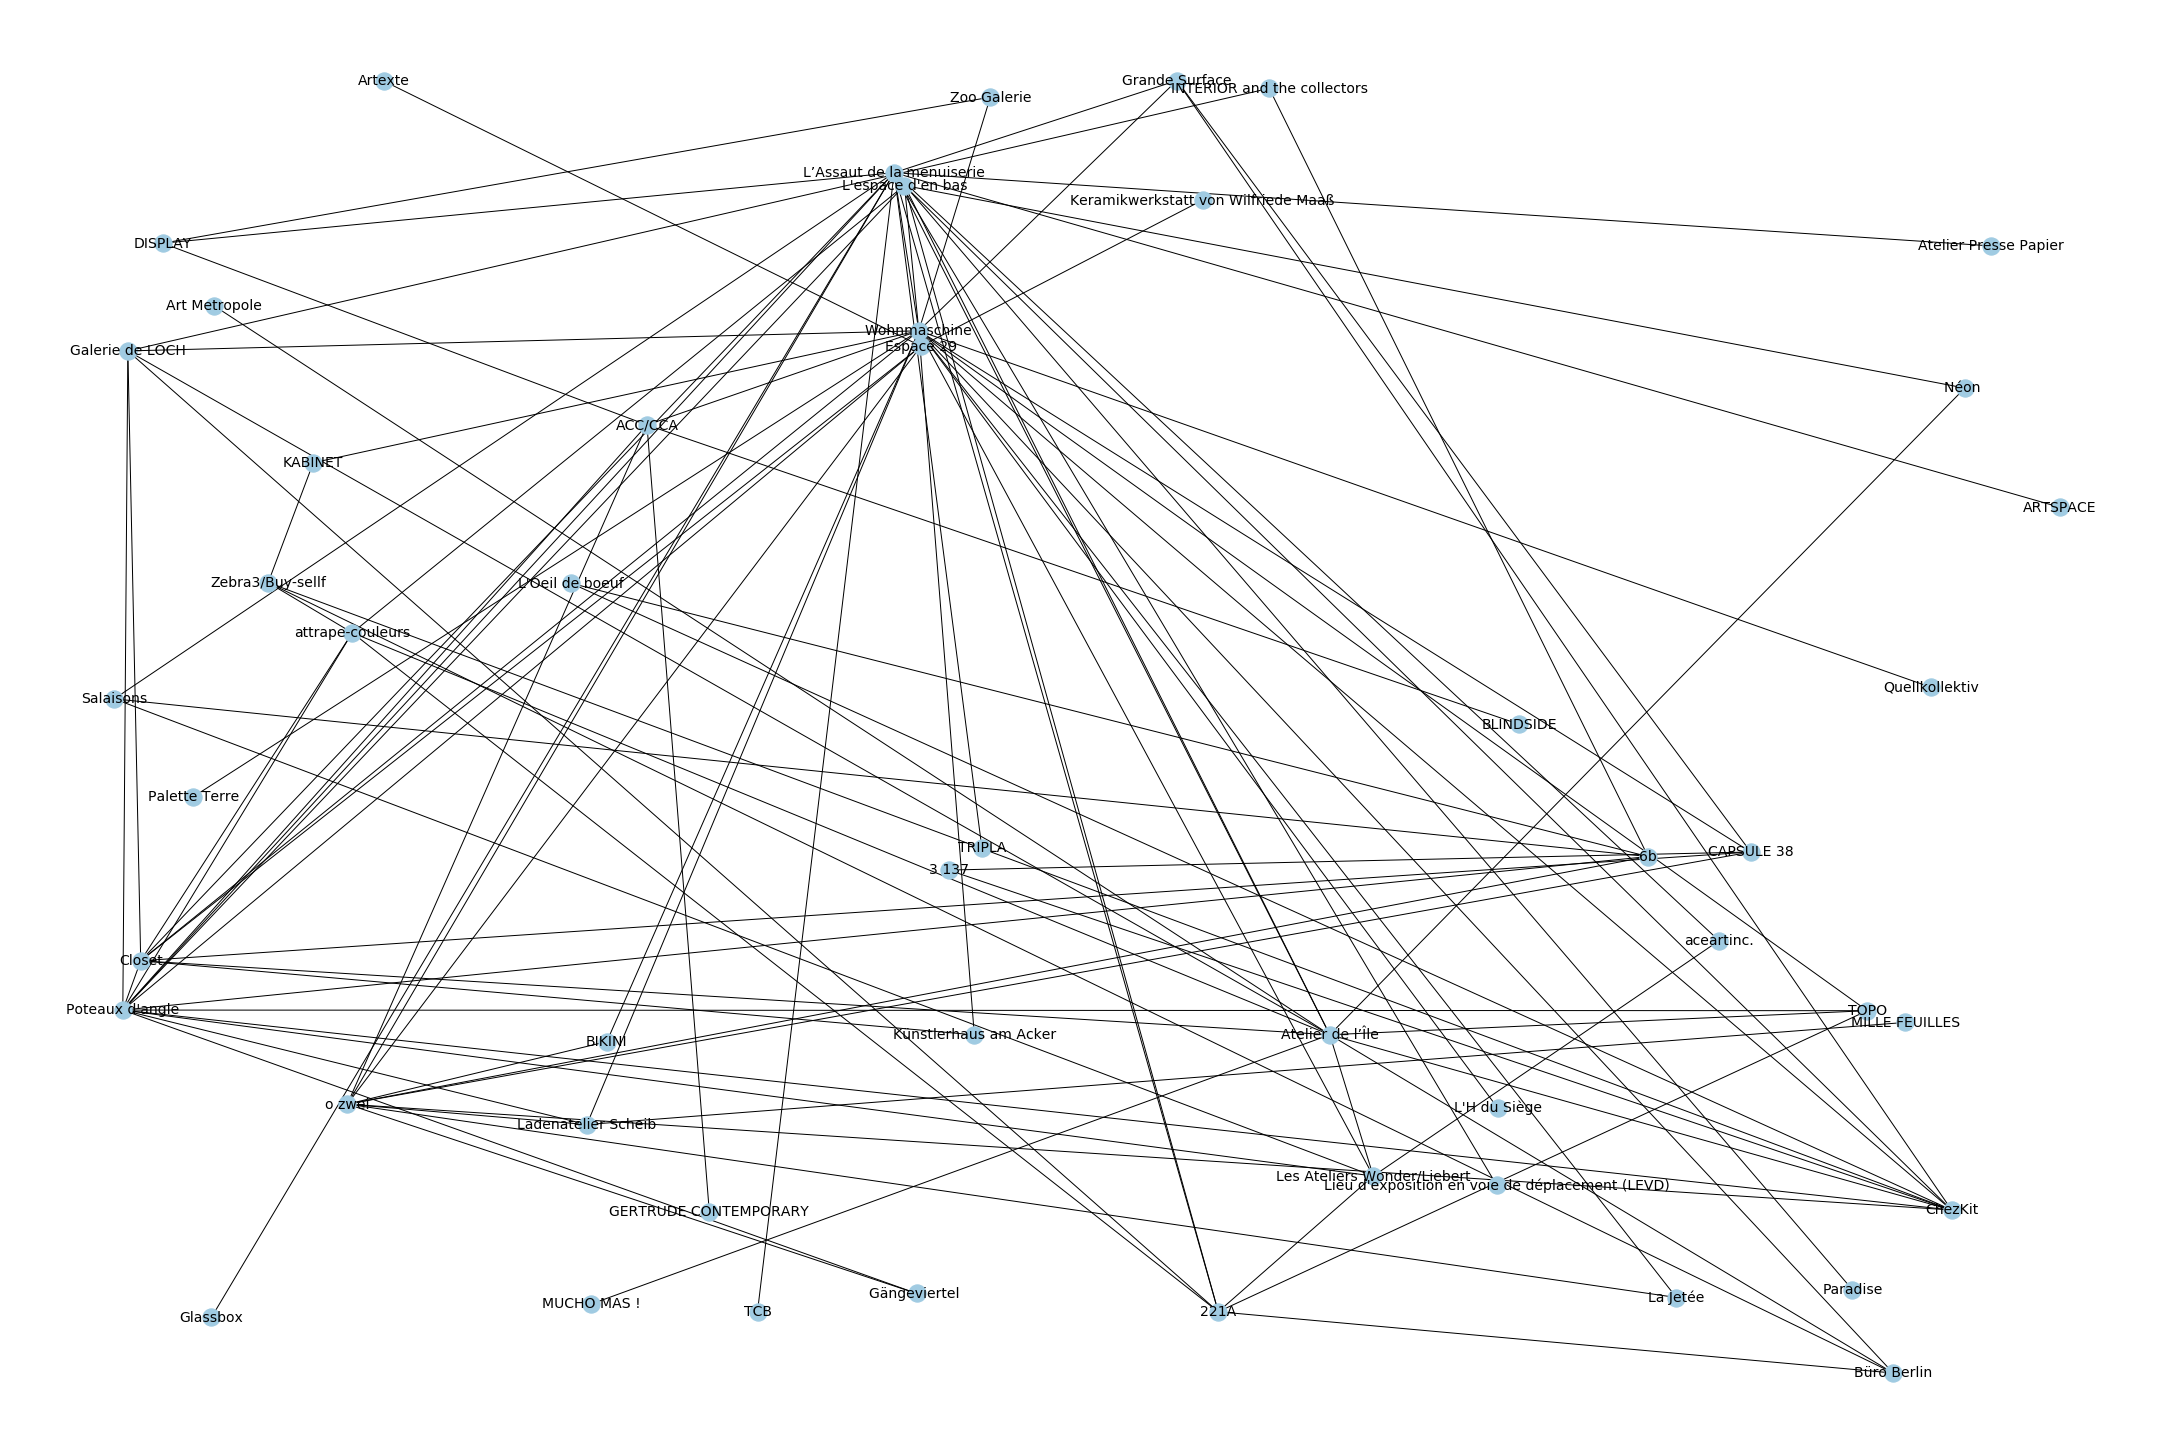

In [904]:
nx.draw_random(G ,
        node_color='#A0CBE2',
        width=1, edge_cmap=plt.cm.Blues,
        font_size=14, with_labels=True) 

In [913]:
TOTAL = json_graph.node_link_data(G)

In [914]:
with open(f'TOTALY.json', 'w') as outfile:
            json.dump(TOTAL, outfile) 

# Clustering for different label  

In [792]:
from sklearn.cluster import DBSCAN , KMeans ,AgglomerativeClustering  

# Kmeans 

In [793]:
def elbow(X,maximal=20): 
    plt.style.use('dark_background')
    distortion=[]
    for i in range(1,maximal): 
        Km=KMeans(n_clusters=i) 
        Km.fit(X) 
        distortion.append(Km.inertia_) 
    plt.plot(distortion)

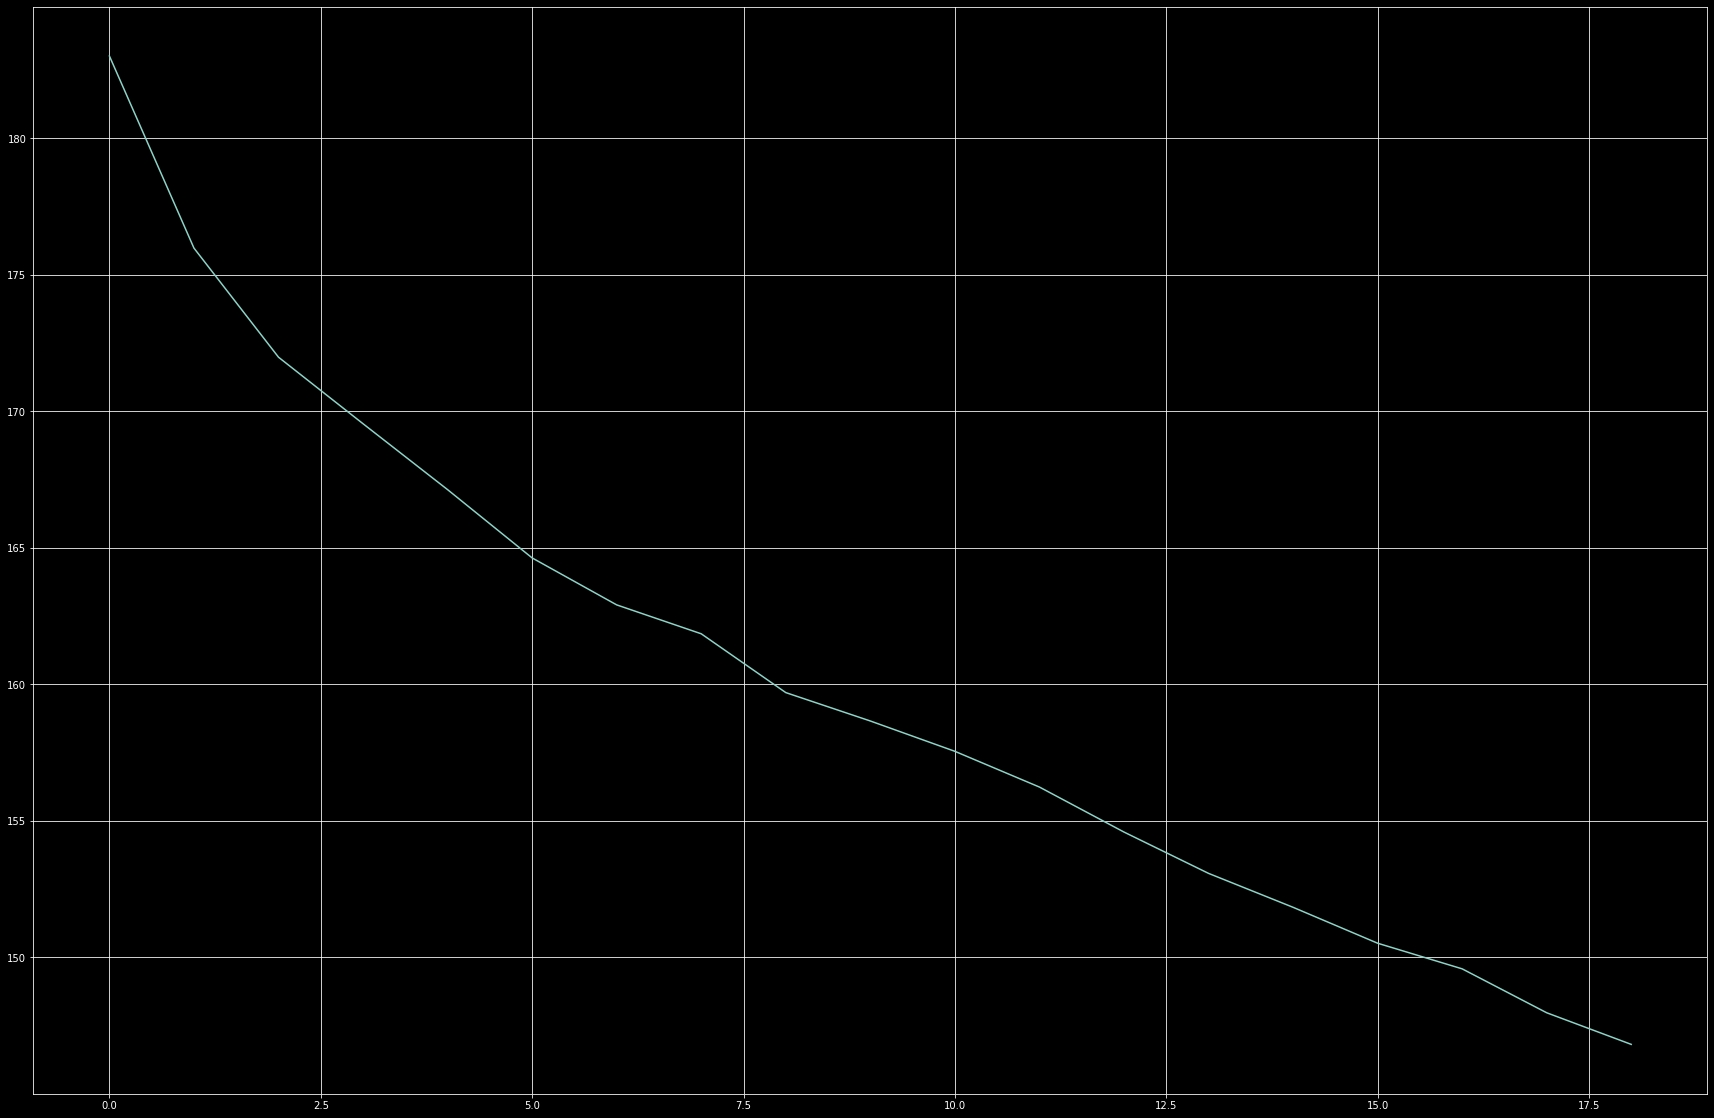

In [794]:
elbow(X,maximal=20) 
plt.grid()

In [795]:
Km=KMeans(n_clusters=8) 
Km.fit(X) 

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=8, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [813]:
from collections import Counter
Counter(Km.labels_)
data_trad['Kmeans']=Km.labels_

In [814]:
def Create_network_clust(label,limits=6): 
    data_trad_label=data_trad[data_trad.Kmeans==label]
    trad_label =data_trad_label['presentation_clean']
    ID_list_label = data_trad_label.index 
    discri=vectorizer.get_feature_names() 
    
    tojson=check_it(Dict,trad_label,ID_list_label,discri) 
    print('tojson done')
    A, B =list(zip(*tojson.keys())) 
    weights = tojson.values() 
    
    Network=pd.DataFrame()
    Network['A']=A
    Network['B']=B 
    Network['WEIGHTS']=weights  
    Network=Network[Network['WEIGHTS'] > Network['WEIGHTS'].quantile(0.6) ]
    print('dataframe created') 
    print(f'lenght of feature in graph construction :{len(discri)}')
    Network.A=Network.A.apply(lambda x : data_trad[['nom']].loc[x].values[0])
    Network.B=Network.B.apply(lambda x : data_trad[['nom']].loc[x].values[0])  
    UNIQUE =set.union(set(Network.A),set(Network.B))
    #G=nx.from_pandas_edgelist(Network , 'A', 'B') 
    G=nx.Graph() 
    G.add_nodes_from(list(UNIQUE)) 
    for i in range(len(Network)): 
        G.add_edge(Network.iloc[i].A,Network.iloc[i].B, value=float(Network.iloc[i].WEIGHTS))
    return G , X , vectorizer, Network

In [815]:
    data_trad_label=data_trad[data_trad.Kmeans==2]
    trad_label =data_trad_label['presentation_clean']
    ID_list_label = data_trad_label.index 
    discri=vectorizer.get_feature_names() 
    
    tojson=check_it(Dict,trad_label,ID_list_label,discri) 

5 étape for outside loop


In [829]:
G_test1,_,_,_, =Create_network_clust(0) 
# G_test2,_,_,_ = Create_network_clust(2) 

tojson done


ValueError: not enough values to unpack (expected 2, got 0)

In [873]:
from networkx.readwrite import json_graph
import json

def Kmeans_json(clust=8): 
    Dict_K={}
    Dict_G={} 
    Dict_F={}
    for j in range(clust):
        print(j)
        try: 
            Gl, Xl, vectorizerl, Networkl=Create_network_clust(j) 
        except:
            continue 
        #for i in Gl.nodes:  
         #   nx.set_node_attributes(Gl,{i : data_trad['date_open'][data_trad['nom']==i]},name='date' )
        CC={} 
        for key,val in nx.clustering(Gl).items(): 
            try :
                date=int(data_trad['date_open'][data_trad['nom']==key].values[0])
            except:
                date = 2018
            CC[key]={'clustering_coeff':val ,'date':date,'degree':Gl.degree()[key]}
        nx.set_node_attributes( Gl,CC) 
        JSON = json_graph.node_link_data(Gl)
        Dict_K[f'cluster{j+1}']=JSON 
        Dict_G[f'cluster{j+1}']=Gl 
        Dict_F[f'cluster{j+1}']=vectorizerl.get_feature_names() 
        with open(f'Kmeans{j}.json', 'w') as outfile:
            json.dump(JSON, outfile) 
    return Dict_K,Dict_G,Dict_F

In [874]:
KMEAN,GRAPH,FEATURE =Kmeans_json()

tojson done
dataframe created
lenght of feature in graph construction :209


In [917]:
LK={}
for key in KMEAN.keys(): 
    LK[key]= list(GRAPH[key].nodes())


# FEATURE WITH TFIDF  

In [954]:
data_clust={} 
for key,val in LK.items(): 
    tmp=data_trad.set_index('nom').transpose() 
    data_clust[key]=tmp[val].transpose()

In [958]:
Count=dict()

In [978]:
for key in data_clust.keys(): 
    tmp=data_clust[key].presentation_clean.sum() 
    tmp2= [] 
    for i in tmp: 
        if 'art' in i : 
            continue
        else :
            tmp2.append(i)
    Count[key]=Counter(tmp2)

In [1038]:
joblib.dump(Count,'comptage_par_cluster.job')
joblib.dump(data_clust,'data_par_cluster.job')

['data_par_cluster.job']

In [1031]:

def cooccurence(key,size=10): 
    talk=data_clust[key].presentation_clean
    vectorizer= TfidfVectorizer(max_features=size, 
                               stop_words=['art','artist','space','artists','artistic'])
    X = vectorizer.fit_transform(talk.apply(lambda x: ' '.join(x))) 
    A = pd.DataFrame(X.todense(),
                 columns=vectorizer.get_feature_names()).apply(lambda x: x != 0)*1  
    COO=A.T.dot(A)  
    
    return COO


In [1040]:
matrix_coo = {} 
for key in data_clust.keys():
    matrix_coo[key]=cooccurence(key)

In [1043]:
joblib.dump(matrix_coo,'matrice_coocurence_par_cluster.job')

['matrice_coocurence_par_cluster.job']

In [1077]:
HEATM=dict()   
for key in matrix_coo.keys():
    x , y , value  = [] , [] , [] 
    testat =matrix_coo[key] 
    SIZE_MATRIX=len(testat)
    skip=0
    for col in testat.columns :  
        value = value + list(testat[col].values)[skip:]
        x = x + list(testat[col].index)[skip:] 
        y = y + [col for _ in range(SIZE_MATRIX)][skip:]
        skip +=1

    tmp=pd.DataFrame() 
    tmp['x']=x
    tmp['y']=y 
    tmp['value']=value 
    HEATM[key]=tmp



In [1081]:
for key,val in HEATM.items(): 
    val.to_csv(f'HEAT_{key}.csv',index=False)

# Co occurence pour tout le data_set 

In [1189]:
def cooc_all(size=10): 
    talk=data_trad.presentation_clean
    vectorizer= TfidfVectorizer(max_df=0.07,max_features=size, 
                               stop_words=['art','artist','space','artists','artistic'])
    X = vectorizer.fit_transform(talk.apply(lambda x: ' '.join(x))) 
    A = pd.DataFrame(X.todense(),
                 columns=vectorizer.get_feature_names()).apply(lambda x: x != 0)*1  
    COO=A.T.dot(A)  
    
    return COO

In [1190]:
All_coo = cooc_all(size=20)

In [1191]:
def Network_dataframe(): 
    x , y , value  = [] , [] , [] 
    SIZE_MATRIX=len(All_coo)
    skip=0
    for col in All_coo.columns :  
        value = value + list(All_coo[col].values)[skip:]
        x = x + list(All_coo[col].index)[skip:] 
        y = y + [col for _ in range(SIZE_MATRIX)][skip:]
        skip +=1
    tmp=pd.DataFrame() 
    tmp['x']=x
    tmp['y']=y 
    tmp['value']=value  
    return tmp 

In [1192]:
Network_dataframe().value.describe()

count    210.000000
mean       1.547619
std        3.196906
min        0.000000
25%        0.000000
50%        1.000000
75%        1.000000
max       14.000000
Name: value, dtype: float64

In [1193]:
def graph_lim(lim=0.9):
    Network_all= Network_dataframe() 
    Net = Network_all[Network_all.value < Network_all.value.quantile(lim)]
    Graph_all=nx.convert_matrix.from_pandas_edgelist(Net,
                                                     source='x', 
                                                     target='y', 
                                                     edge_attr='value') 
    return Graph_all

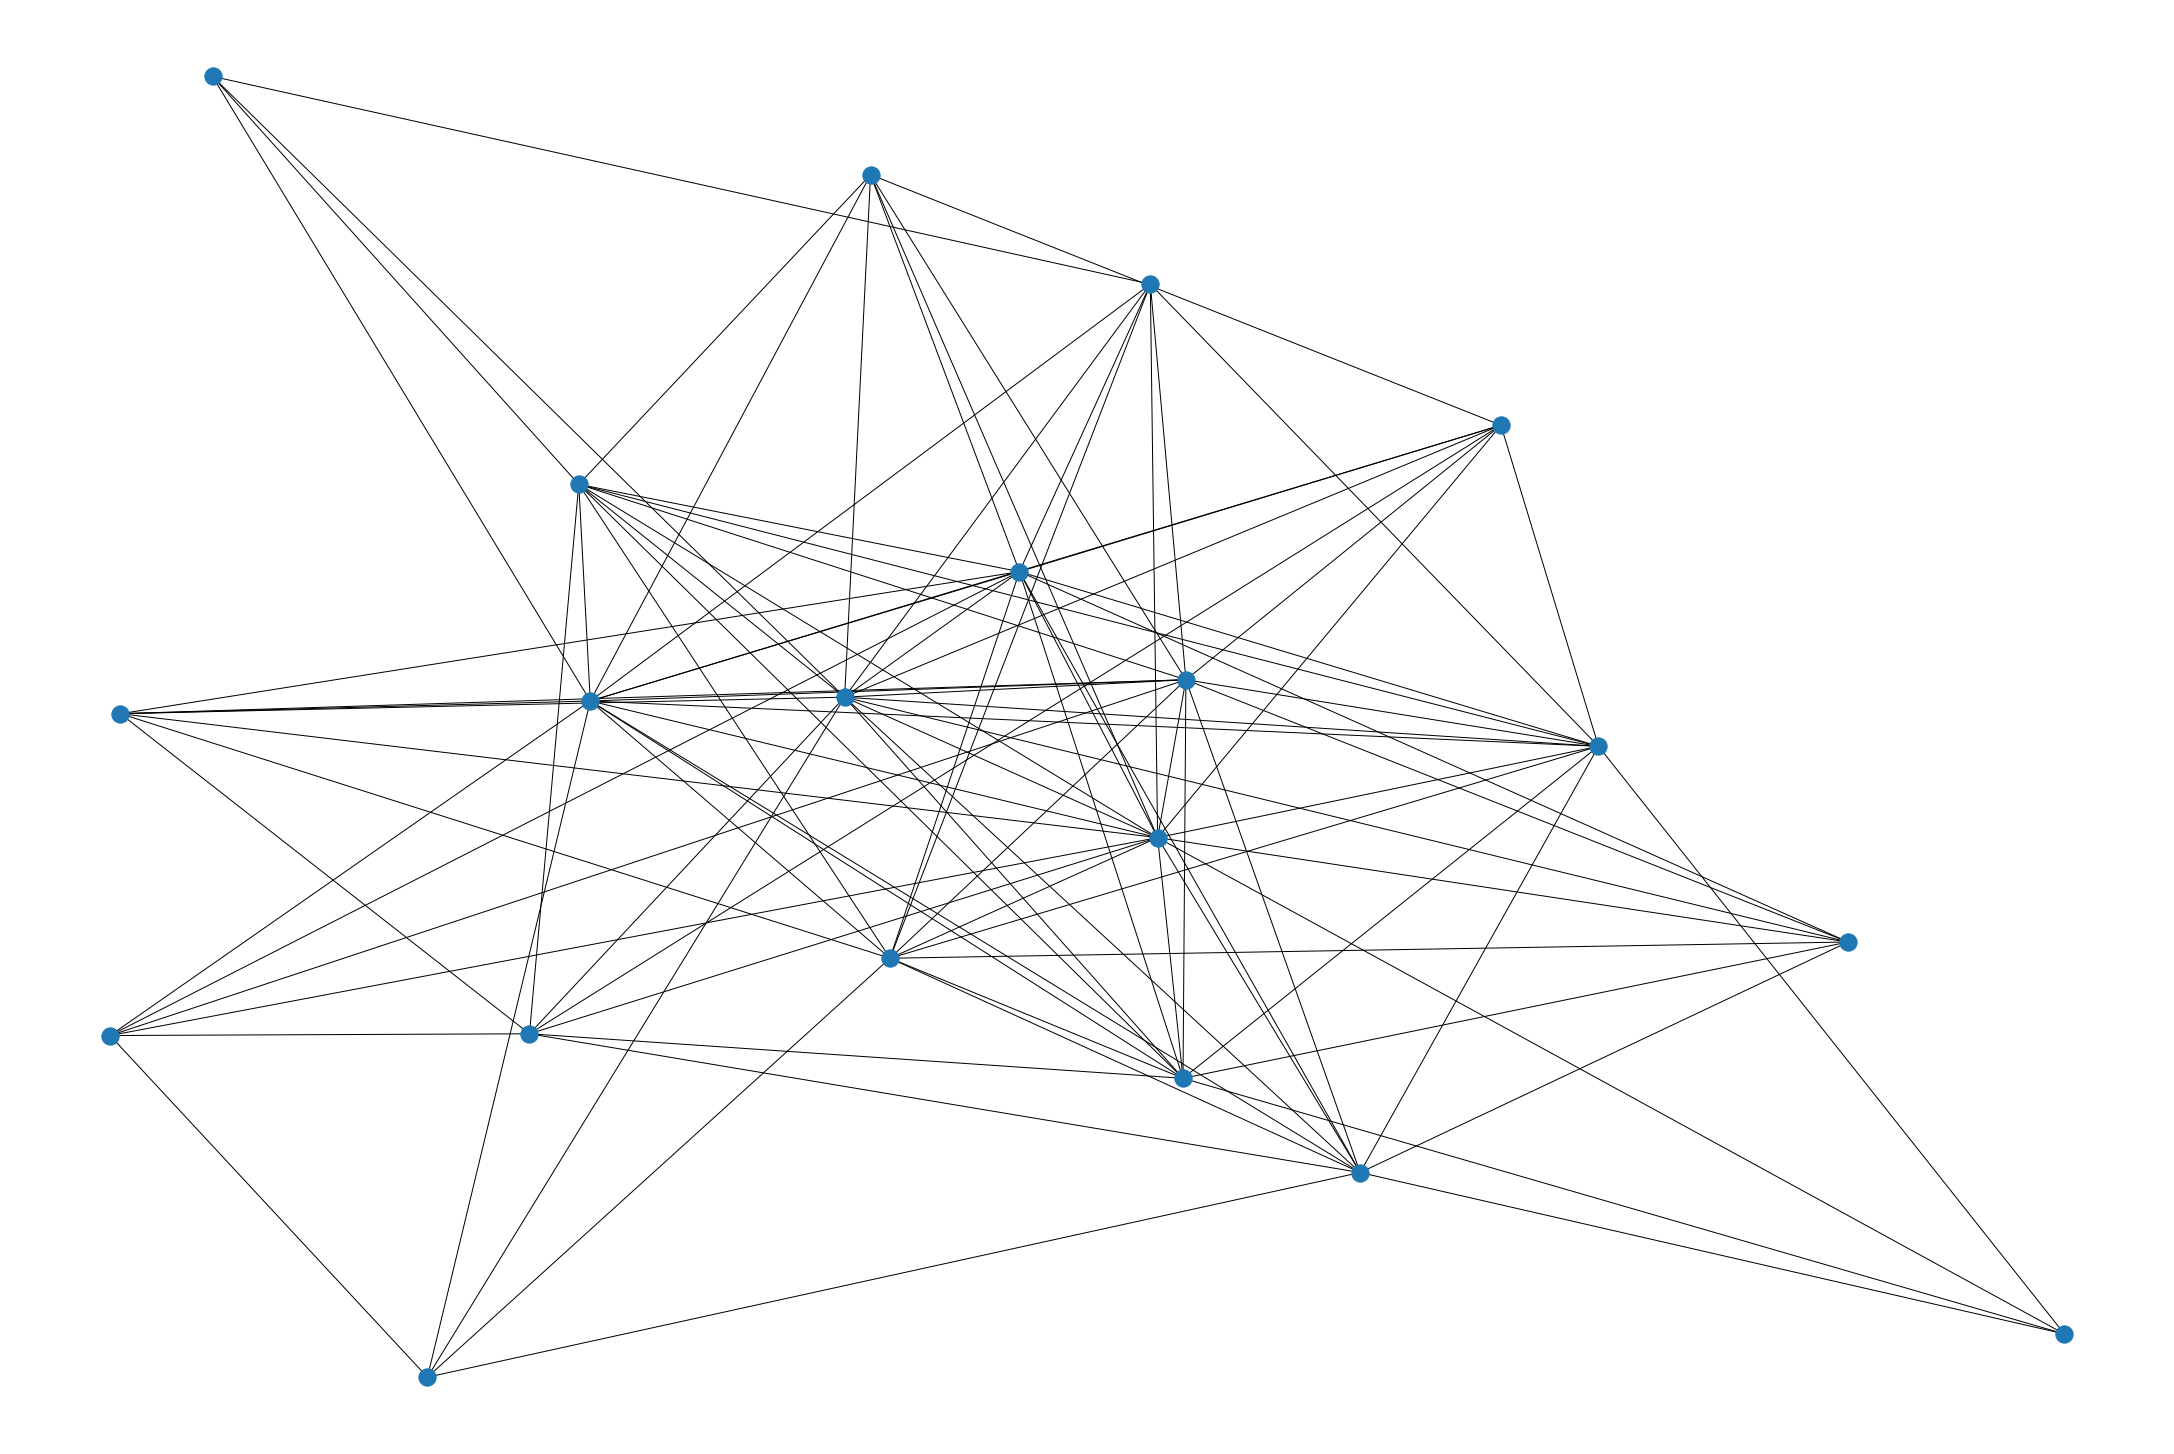

In [1194]:
G_all= graph_lim(0.75)
nx.draw(G_all)

In [1200]:
CC={}
for key,val in nx.clustering(G_all).items(): 
    try :
        date=int(data_trad['date_open'][data_trad['nom']==key].values[0])
    except:
        date = 2018
    CC[key]={'clustering_coeff':val ,'date':date,'degree':G_all.degree()[key]}
nx.set_node_attributes( G_all,CC) 

In [1202]:
json_all=nx.node_link_data(G_all)

In [1203]:
with open(f'Word_for_graph.json', 'w') as outfile:
            json.dump(json_all, outfile) 

In [1205]:
joblib.dump(data_trad,'dataframe_traduite.csv')

['dataframe_traduite.csv']